## Import Libs

In [55]:
#Libs
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import joblib
import os
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb

## Load and Inspect Data

In [56]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Inspect data
print(train_df.head())
print(train_df.info())
print(train_df.describe())

   ID                            fullAddress postcode  country outcode  \
0   0       38 Adelina Grove, London, E1 3AD   E1 3AD  England      E1   
1   1      6 Cleveland Grove, London, E1 4XL   E1 4XL  England      E1   
2   2   65 Sanderstead Road, London, E10 7PW  E10 7PW  England     E10   
3   3  5 Queenswood Gardens, London, E11 3SE  E11 3SE  England     E11   
4   4     12 Woodlands Road, London, E11 4RW  E11 4RW  England     E11   

    latitude  longitude  bathrooms  bedrooms  floorAreaSqM  livingRooms  \
0  51.519406  -0.053261        NaN       3.0          80.0          1.0   
1  51.521261  -0.053384        2.0       4.0         110.0          1.0   
2  51.569054  -0.034892        1.0       3.0          84.0          1.0   
3  51.564212   0.026292        NaN       2.0          72.0          1.0   
4  51.563430   0.006260        1.0       3.0         104.0          1.0   

      tenure         propertyType currentEnergyRating  sale_month  sale_year  \
0   Freehold  Semi-Detac

## Handling Missing Values

Missing Values Summary:
                      Missing Values  Percentage (%)
currentEnergyRating           56814       21.332582
bathrooms                     48479       18.202948
livingRooms                   37040       13.907819
bedrooms                      24843        9.328077
floorAreaSqM                  13806        5.183892
tenure                         5721        2.148127
propertyType                    508        0.190744
ID                                0        0.000000
fullAddress                       0        0.000000
latitude                          0        0.000000
longitude                         0        0.000000
country                           0        0.000000
outcode                           0        0.000000
postcode                          0        0.000000
sale_month                        0        0.000000
sale_year                         0        0.000000
price                             0        0.000000


/tmp/ipython-input-3485912033.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


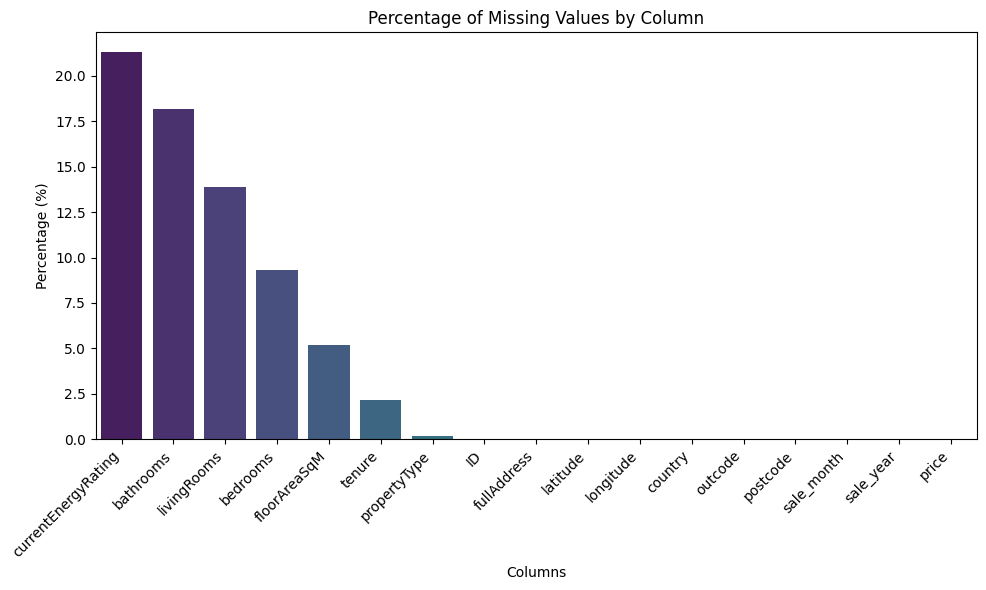

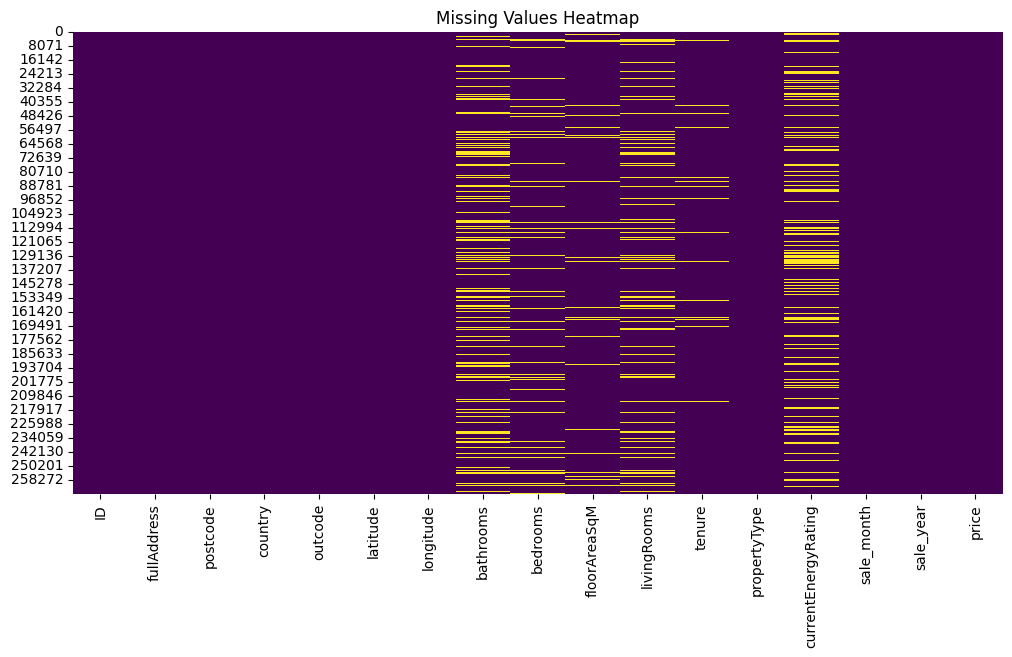

In [57]:
# Identify missing values (count and percentage)
missing_counts = train_df.isnull().sum()
missing_percent = (missing_counts / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percent
}).sort_values(by='Missing Values', ascending=False)

print("Missing Values Summary:\n", missing_df)

# Visualise missing values
plt.figure(figsize=(10, 6))
sns.barplot(
    x=missing_df.index,
    y='Percentage (%)',
    data=missing_df,
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

# Heatmap to see missing value pattern
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [58]:
# Fill numarical columns with median
numeric_cols = ['bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms']
for col in numeric_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

# Fill categorical columns with mode
categorical_cols = ['tenure', 'propertyType', 'currentEnergyRating']
for col in categorical_cols:
    mode_val = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_val)
    test_df[col] = test_df[col].fillna(mode_val)

In [59]:
print(train_df.isnull().sum())

ID                     0
fullAddress            0
postcode               0
country                0
outcode                0
latitude               0
longitude              0
bathrooms              0
bedrooms               0
floorAreaSqM           0
livingRooms            0
tenure                 0
propertyType           0
currentEnergyRating    0
sale_month             0
sale_year              0
price                  0
dtype: int64


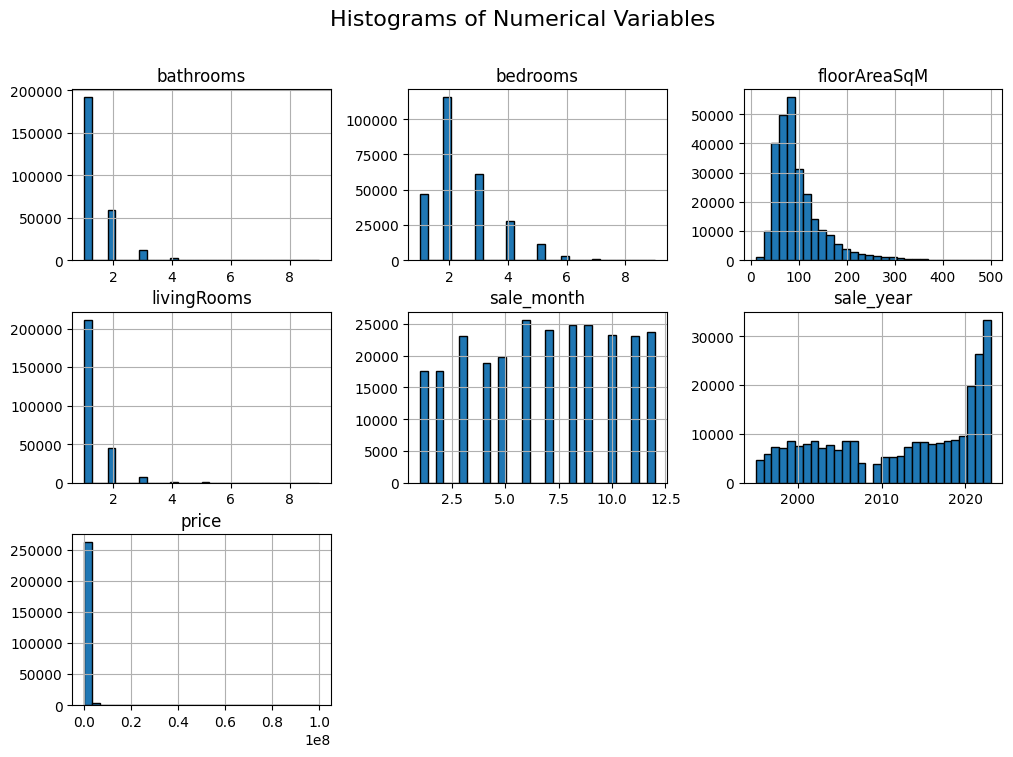

In [60]:
numerical_cols = [
    'bathrooms', 'bedrooms', 'floorAreaSqM',
    'livingRooms', 'sale_month', 'sale_year', 'price'
]

train_df[numerical_cols].hist(
    bins=30, figsize=(12, 8), edgecolor='black'
)
plt.suptitle("Histograms of Numerical Variables", fontsize=16)
plt.show()

/tmp/ipython-input-2115544597.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-2115544597.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-2115544597.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


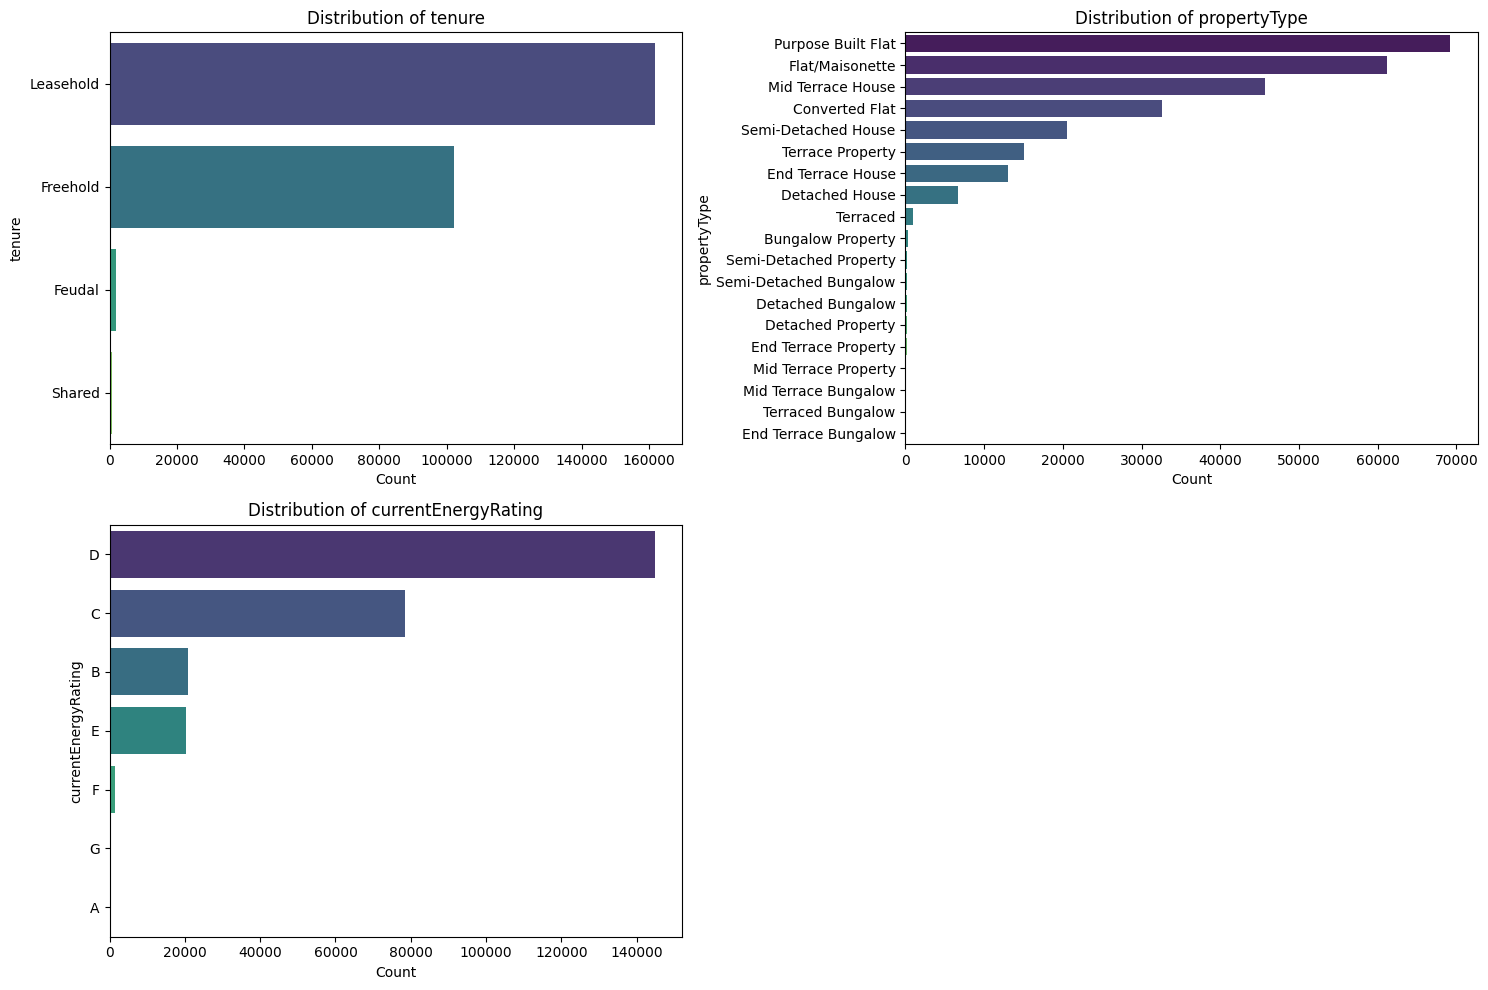

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = ['tenure', 'propertyType', 'currentEnergyRating']

plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(
        y=col,
        data=train_df,
        order=train_df[col].value_counts().index,
        palette='viridis'
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [62]:
train_df.head()

,ID,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,sale_month,sale_year,price
0,0,"38 Adelina Grove, London, E1 3AD",E1 3AD,England,E1,51.519406,-0.053261,1.0,3.0,80.0,1.0,Freehold,Semi-Detached House,C,1,1995,77000
1,1,"6 Cleveland Grove, London, E1 4XL",E1 4XL,England,E1,51.521261,-0.053384,2.0,4.0,110.0,1.0,Leasehold,Terrace Property,D,1,1995,89995
2,2,"65 Sanderstead Road, London, E10 7PW",E10 7PW,England,E10,51.569054,-0.034892,1.0,3.0,84.0,1.0,Freehold,Terrace Property,D,1,1995,59000
3,3,"5 Queenswood Gardens, London, E11 3SE",E11 3SE,England,E11,51.564212,0.026292,1.0,2.0,72.0,1.0,Leasehold,Purpose Built Flat,D,1,1995,51500
4,4,"12 Woodlands Road, London, E11 4RW",E11 4RW,England,E11,51.563430,0.006260,1.0,3.0,104.0,1.0,Freehold,Mid Terrace House,D,1,1995,63500


# Data Processing

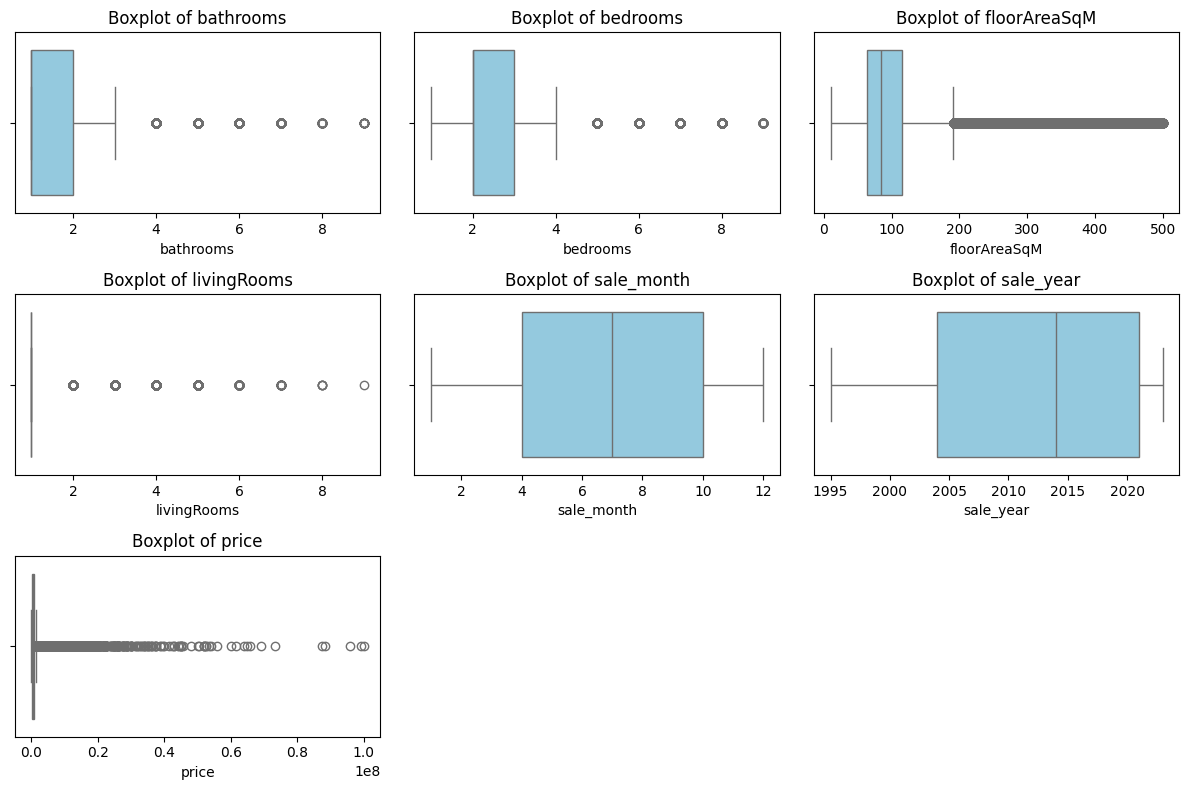

In [63]:
# Numerical variables to check for outliers
numerical_vars = [
    'bathrooms', 'bedrooms', 'floorAreaSqM',
    'livingRooms', 'sale_month', 'sale_year', 'price'
]

# Plot boxplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


## Remove Outliers

In [64]:
# Remove outliers beyond 3 standard deviations for price
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1
train_df = train_df[(train_df['price'] >= Q1 - 1.5 * IQR) & (train_df['price'] <= Q3 + 1.5 * IQR)]

## Feature Engineering

In [65]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    # Compute differences in coordinates
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    # Apply the Haversine formula
    sin_lat = np.sin(delta_lat / 2.0)
    sin_lon = np.sin(delta_lon / 2.0)
    a = sin_lat**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * sin_lon**2
    central_angle = 2 * np.arcsin(np.sqrt(a))
    # Multiply by Earth's radius (in kilometers)
    earth_radius_km = 6371.0
    distance_km = earth_radius_km * central_angle
    return distance_km

landmarks = {
    'centre':        (51.5074, -0.1278),   # Charing Cross
    'city':          (51.5155, -0.0922),   # City of London
    'canary_wharf':  (51.5054, -0.0235),   # Canary Wharf
    'heathrow':      (51.4700, -0.4543),   # Heathrow Airport
    'chelsea':       (51.4869, -0.1700),     # Chelsea
    'mayfair':       (51.5116, -0.1478),      # mayfair
    'knightsbridge': (51.4991, -0.1644),      # knightsbridge
}

for df in (train_df, test_df):
    df['total_rooms'] = df['bedrooms'] + df['bathrooms'] + df['livingRooms']
    df['property_age'] = df['sale_year'].max() - df['sale_year']
    df['postcode_area'] = df['postcode'].str.extract(r'^([A-Za-z]{1,2})')
    df['postcode_district'] = df['postcode'].str.extract(r'^[A-Za-z]{1,2}(\d{1,2})')
    for name, (lat_ref, lon_ref) in landmarks.items():
        feature_name = f'dist_to_{name}'
        df[feature_name] = haversine_distance(
            df['latitude'], df['longitude'],
            lat_ref, lon_ref
        )


In [66]:
train_df.head()

,ID,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,...,property_age,postcode_area,postcode_district,dist_to_centre,dist_to_city,dist_to_canary_wharf,dist_to_heathrow,dist_to_chelsea,dist_to_mayfair,dist_to_knightsbridge
0,0,"38 Adelina Grove, London, E1 3AD",E1 3AD,England,E1,51.519406,-0.053261,1.0,3.0,80.0,...,28,E,1,5.328086,2.729140,2.582087,28.301627,8.851789,6.599152,8.016120
1,1,"6 Cleveland Grove, London, E1 4XL",E1 4XL,England,E1,51.521261,-0.053384,2.0,4.0,110.0,...,28,E,1,5.375223,2.761141,2.717884,28.333503,8.930150,6.620920,8.068394
2,2,"65 Sanderstead Road, London, E10 7PW",E10 7PW,England,E10,51.569054,-0.034892,1.0,3.0,84.0,...,28,E,10,9.396264,7.153218,7.121769,31.039063,13.069330,10.089047,11.863794
3,3,"5 Queenswood Gardens, London, E11 3SE",E11 3SE,England,E11,51.564212,0.026292,1.0,2.0,72.0,...,28,E,11,12.389417,9.823148,7.390986,34.865258,16.072111,13.386639,15.046941
4,4,"12 Woodlands Road, London, E11 4RW",E11 4RW,England,E11,51.563430,0.006260,1.0,3.0,104.0,...,28,E,11,11.171159,8.647204,6.773025,33.519027,14.869788,12.114064,13.803150


## Drop unnecessary columns

In [67]:
drop_cols = ['ID', 'fullAddress', 'postcode', 'country', 'outcode', 'latitude',
             'longitude', 'sale_month', 'sale_year']
train_df = train_df.drop(columns=drop_cols, errors='ignore')
test_df_ids = test_df['ID']
test_df = test_df.drop(columns=drop_cols, errors='ignore')

In [68]:
print(train_df.head())

   bathrooms  bedrooms  floorAreaSqM  livingRooms     tenure  \
0        1.0       3.0          80.0          1.0   Freehold   
1        2.0       4.0         110.0          1.0  Leasehold   
2        1.0       3.0          84.0          1.0   Freehold   
3        1.0       2.0          72.0          1.0  Leasehold   
4        1.0       3.0         104.0          1.0   Freehold   

          propertyType currentEnergyRating  price  total_rooms  property_age  \
0  Semi-Detached House                   C  77000          5.0            28   
1     Terrace Property                   D  89995          7.0            28   
2     Terrace Property                   D  59000          5.0            28   
3   Purpose Built Flat                   D  51500          4.0            28   
4    Mid Terrace House                   D  63500          5.0            28   

  postcode_area postcode_district  dist_to_centre  dist_to_city  \
0             E                 1        5.328086      2.729140   


In [69]:
test_df.head()

,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,total_rooms,property_age,postcode_area,postcode_district,dist_to_centre,dist_to_city,dist_to_canary_wharf,dist_to_heathrow,dist_to_chelsea,dist_to_mayfair,dist_to_knightsbridge
0,1.0,2.0,54.0,1.0,Leasehold,Flat/Maisonette,D,4.0,0,E,1,4.129175,1.511475,3.608400,27.084009,7.714995,5.373859,6.824215
1,1.0,1.0,48.0,1.0,Leasehold,Purpose Built Flat,D,3.0,0,E,1,4.148889,1.713442,3.172434,27.126676,7.561741,5.506089,6.799888
2,1.0,2.0,32.0,1.0,Leasehold,Flat/Maisonette,C,4.0,0,E,1,4.283442,1.804613,3.085836,27.265918,7.718785,5.627396,6.943266
3,1.0,3.0,85.0,1.0,Leasehold,Purpose Built Flat,D,5.0,0,E,1,4.972855,2.413727,2.629669,27.957596,8.450205,6.280726,7.649004
4,1.0,2.0,82.0,1.0,Leasehold,Flat/Maisonette,C,4.0,0,E,1,5.383055,2.850679,2.188866,28.367664,8.813797,6.709406,8.047326


## Prepare Data for Modeling

In [70]:
# Separate features (X) and target variable (y)
X = train_df.drop('price', axis=1)
y = train_df['price']

# One-hot encode categorical variables and drop the
#first category to avoid dummy variable trap
x_encoded_test = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    x_encoded_test, y, test_size=0.2, random_state=42
)

# Standardise the numerical features to have mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train and Test

## Try different models

In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(tree_method="hist", n_estimators=500, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=500, random_state=42)
}

use_scaled = {"LinearRegression", "SVR"}

def evaluate(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    r2   = r2_score(yte, pred)
    return rmse, r2

rows = []

for name, model in models.items():
    Xtr = X_train_scaled if name in use_scaled else X_train
    Xte = X_test_scaled  if name in use_scaled else X_test
    rmse, r2 = evaluate(model, Xtr, Xte, y_train, y_test)
    rows.append({"Model": name, "RMSE": rmse, "R2": r2})

results = pd.DataFrame(rows).sort_values(by="RMSE")
print(results.to_string(index=False))

best = results.iloc[0]
print(f"\nBest model: {best['Model']}  |  RMSE: {best['RMSE']:.2f}  |  R2: {best['R2']:.3f}")

## Final Stacking Regressor

In [ ]:
stacked_model = StackingRegressor(
    estimators=[
        ('xgb', XGBRegressor(random_state=42)),
        ('lgbm', LGBMRegressor(random_state=42)),
        ('cb', CatBoostRegressor(verbose=0, random_state=42)), # verbose=0 for cleaner output
    ],
    final_estimator=LinearRegression()
)

stacked_model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = stacked_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
accuracy_percent = r2 * 100


# Display results
print(f"Model Name: {type(stacked_model).__name__}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")
print(f"Accuracy (%): {accuracy_percent}")

# Feature Scaling and Final Model

# Export AI Model and Scaler

In [ ]:
# Save the trained model
joblib.dump(stacked_model, 'stacked_model.pkl')

# Save the fitted scaler
joblib.dump(scaler, 'scaler.pkl')

print("Model saved to stacked_model.pkl")
print("Scaler saved to scaler.pkl")

Model saved to stacked_model.pkl
Scaler saved to scaler.pkl


# New section

In [ ]:
# --- Encode test with the SAME dummies used for train ---
test_X_encoded = pd.get_dummies(test_df, drop_first=True)

# Align columns: add missing cols as 0, drop extras
test_X_encoded = test_X_encoded.reindex(columns=x_encoded_test.columns, fill_value=0)

# --- Scale with the SAME scaler used on train ---
test_X_scaled = scaler.transform(test_X_encoded)

# --- Predict with the trained stacked model ---
test_preds = stacked_model.predict(test_X_scaled)

submission = pd.DataFrame({
    'ID': test_df_ids,
    'price': test_preds
})

submission.to_csv('kaggle_submission.csv', index=False)
print("Saved: kaggle_submission.csv")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Saved: kaggle_submission.csv


# Export the training columns

In [ ]:
# === EXPORT ARTIFACTS FOR WEB APP (RUN ONCE) ===
# This block saves:
#  1) final_feature_columns.json  -> exact model input columns (order matters)
#  2) training_refs.json          -> constants used in feature engineering (sale_year_max)
#  3) landmarks.json              -> coordinates used to compute distance features
#
# Notes:
# - It reads sale_year_max from the RAW train.csv to avoid KeyError if 'sale_year' was dropped.
# - It expects your notebook already created `x_encoded_test` (encoded training features).

import os, json
import pandas as pd

# ---- 0) Paths ----
ART_DIR = "artifacts"
RAW_TRAIN_PATH = "train.csv"   # change if your raw training file is elsewhere

os.makedirs(ART_DIR, exist_ok=True)

# ---- 1) Final model column order (must match training exactly) ----
# Ensure x_encoded_test exists (the same columns were used for scaler/model training)
try:
    final_cols = x_encoded_test.columns.tolist()
except NameError as e:
    raise RuntimeError(
        "x_encoded_test is not defined. Please run the cell that creates "
        "`x_encoded_test = pd.get_dummies(X, drop_first=True)` and aligns columns "
        "before running this export block."
    ) from e

with open(f"{ART_DIR}/final_feature_columns.json", "w") as f:
    json.dump(final_cols, f, indent=2)

print(f"[OK] Saved {ART_DIR}/final_feature_columns.json (n_cols={len(final_cols)})")

# ---- 2) Training constants used in feature engineering ----
# We compute sale_year_max from the RAW dataset (before any drops),
# so this works even if 'sale_year' was dropped in your working DataFrame.
try:
    train_raw = pd.read_csv(RAW_TRAIN_PATH)
except FileNotFoundError as e:
    raise RuntimeError(
        f"Could not read '{RAW_TRAIN_PATH}'. Set RAW_TRAIN_PATH to your raw training CSV."
    ) from e

if "sale_year" not in train_raw.columns:
    raise RuntimeError(
        "Column 'sale_year' not found in the raw training CSV. "
        "Please confirm your raw file path or the column name."
    )

sale_year_max = int(train_raw["sale_year"].max())

with open(f"{ART_DIR}/training_refs.json", "w") as f:
    json.dump({"sale_year_max": sale_year_max}, f, indent=2)

print(f"[OK] Saved {ART_DIR}/training_refs.json (sale_year_max={sale_year_max})")

# ---- 3) Landmarks dictionary (use EXACT values you trained with) ----
# Replace these with the same coordinates you used during training in this notebook.
landmarks = {
    "centre": [51.5074, -0.1278],
    "city": [51.5136, -0.0890],
    "canary_wharf": [51.5054, -0.0235],
    "heathrow": [51.4700, -0.4543],
    "chelsea": [51.4876, -0.1684],
    "mayfair": [51.5090, -0.1490],
    "knightsbridge": [51.5010, -0.1600],
}

with open(f"{ART_DIR}/landmarks.json", "w") as f:
    json.dump(landmarks, f, indent=2)

print(f"[OK] Saved {ART_DIR}/landmarks.json (keys={list(landmarks.keys())})")

print("\nAll export artifacts are ready in the 'artifacts' folder.")


[OK] Saved artifacts/final_feature_columns.json (n_cols=74)
[OK] Saved artifacts/training_refs.json (sale_year_max=2023)
[OK] Saved artifacts/landmarks.json (keys=['centre', 'city', 'canary_wharf', 'heathrow', 'chelsea', 'mayfair', 'knightsbridge'])

All export artifacts are ready in the 'artifacts' folder.


In [ ]:
import sys, sklearn, numpy, scipy
print("Python:", sys.version)
print("sklearn:", sklearn.__version__)
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
sklearn: 1.6.1
numpy: 2.0.2
scipy: 1.16.1
